Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


In [1]:
from gx_utils import *

In [2]:
import logging
import random
from collections import deque, defaultdict
from itertools import combinations, product

logging.basicConfig(format="%(message)s", level=logging.INFO)

In [3]:
from matplotlib import pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Tree Search

## Problem

Given an array of positive integers, find the minimum number of elements that sum to a given number.

In [4]:
def elements2label(elements):
    if not elements:
        return "*"
    else:
        return "-".join(str(_) for _ in sorted(elements))

In [31]:
def problem(array_length, display_graph=False):
    random.seed(13)
    array = [random.randint(1, 20) for _ in range(array_length)]
    goal = sum(random.sample(array, array_length // 2))
    logging.info(f"{array} -> {goal}")

    if display_graph:
        graph = nx.DiGraph()

        labels = dict()
        for size in range(array_length + 1):
            for elements in combinations(array, size):
                node = tuple(sorted(elements))
                graph.add_node(node)
                labels[node] = elements2label(elements)

        for n in graph.nodes:
            graph.nodes[n]["color"] = "lime" if sum(n) == 0 or sum(n) == goal else "lavender"

        for n1, n2 in combinations(graph.nodes, 2):
            s1 = Multiset(n1)
            s2 = Multiset(n2)
            if s2 > s1 and len(s2 - s1) == 1:
                graph.add_edge(n1, n2)

        plt.figure(figsize=(15, 9))
        nx.draw(
            graph,
            pos=graphviz_layout(graph, prog="dot"),
            with_labels=True,
            labels=labels,
            node_color=[c for _, c in graph.nodes(data="color")],
            node_size=1500,
        )

    return array, goal

## Tree Search

In [32]:
def equivalent(state_1, state_2):
    return all(sorted(t1) == sorted(t2) for t1, t2 in zip(state_1, state_2))

In [33]:
def tree_search(blocks, goal, strategy="bf", bound=False):
    tree = nx.DiGraph()
    frontier = deque()

    frontier.append(((), tuple(blocks)))

    n = 0
    while frontier:
        n += 1
        if strategy == "bf":
            state = frontier.popleft()
        elif strategy == "df":
            state = frontier.pop()
        else:
            assert False, "Unknown strategy"

        current_bag, available_blocks = state
        tree.add_node(state)
        tree.nodes[state]["color"] = "yellow"
        tree.nodes[state]["order"] = n

        if sum(current_bag) == goal:
            logging.info(f"Found a solution in {n:,} steps: {current_bag}")
            tree.nodes[state]["color"] = "lime"
            break
        elif bound is True and sum(current_bag) > goal:
            tree.nodes[state]["color"] = "red"
            continue

        tree.nodes[state]["color"] = "skyblue"
        for i, object in enumerate(available_blocks):
            new_state = (
                tuple((*current_bag, object)),
                tuple(available_blocks[:i] + available_blocks[i + 1 :]),
            )
            tree.add_node(new_state, color="lavender")
            tree.nodes[new_state]["label"] = elements2label(new_state[0])
            tree.add_edge(state, new_state, label=object)
            frontier.append(new_state)

    tree.add_node(((), tuple(blocks)), color="lime", label="*")
    if bound == "mark":
        for bounded in [n for n in tree.nodes if sum(n[0]) > goal]:
            tree.nodes[bounded]["color"] = "pink"
    for n in tree.nodes:
        tree.nodes[n]["count"] = -1
    for n1, n2 in product(tree.nodes, repeat=2):
        if equivalent(n1, n2):
            tree.nodes[n1]["count"] += 1
            tree.nodes[n2]["count"] += 1

    return tree

## BF

[9, 10, 6, 8, 5] -> 15
Found a solution in 8 steps: (9, 6)


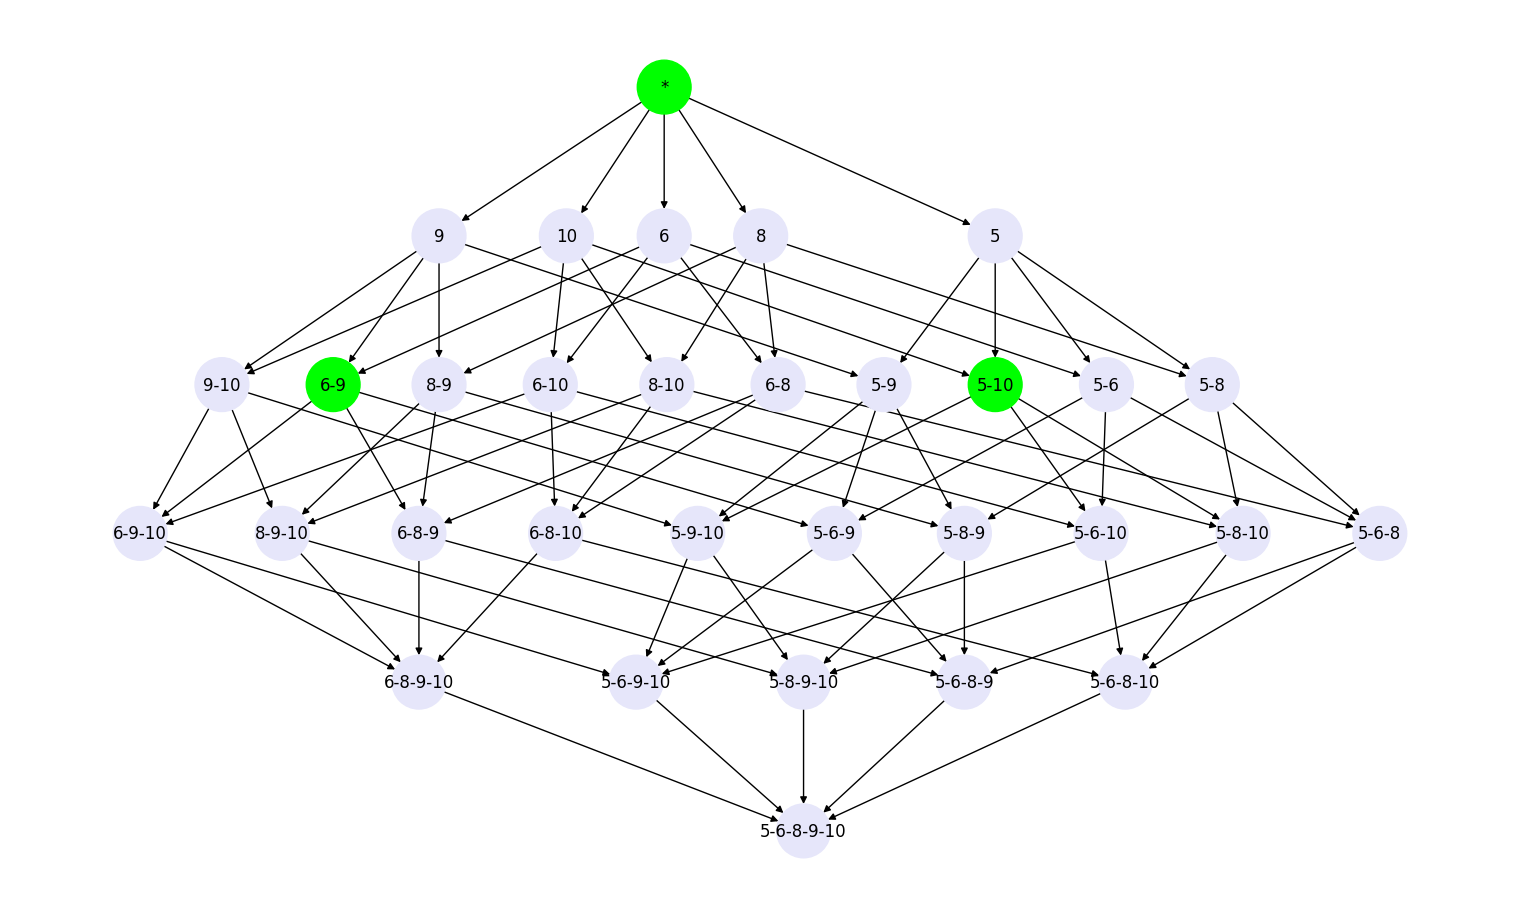

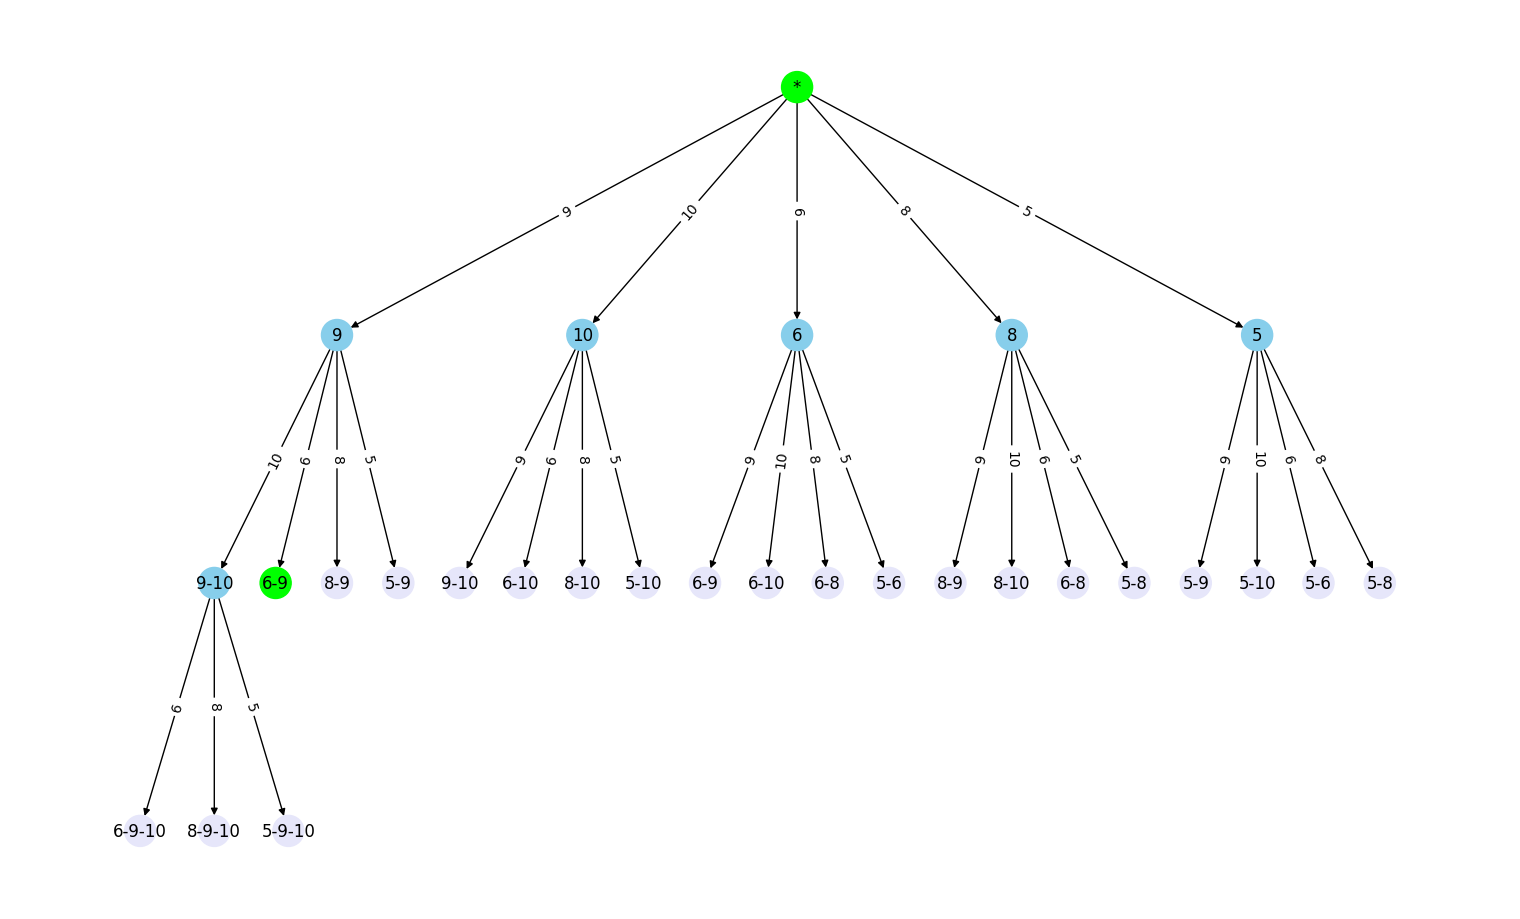

In [34]:
array, goal = problem(5, display_graph=True)
tree = tree_search(array, goal)

plt.figure(figsize=(15, 9))
pos = graphviz_layout(tree, prog="dot")  # dot neato twopi circo fdp sfdp
nx.draw(
    tree,
    pos=pos,
    node_color=[c for _, c in tree.nodes(data="color")],
    with_labels=True,
    labels={n: l for n, l in tree.nodes.data("label")},
    node_size=500,
)
nx.draw_networkx_edge_labels(tree, pos=pos, edge_labels=nx.get_edge_attributes(tree, "label"))
None

## DF

[9, 10, 6, 8, 5] -> 15
Found a solution in 35 steps: (5, 10)


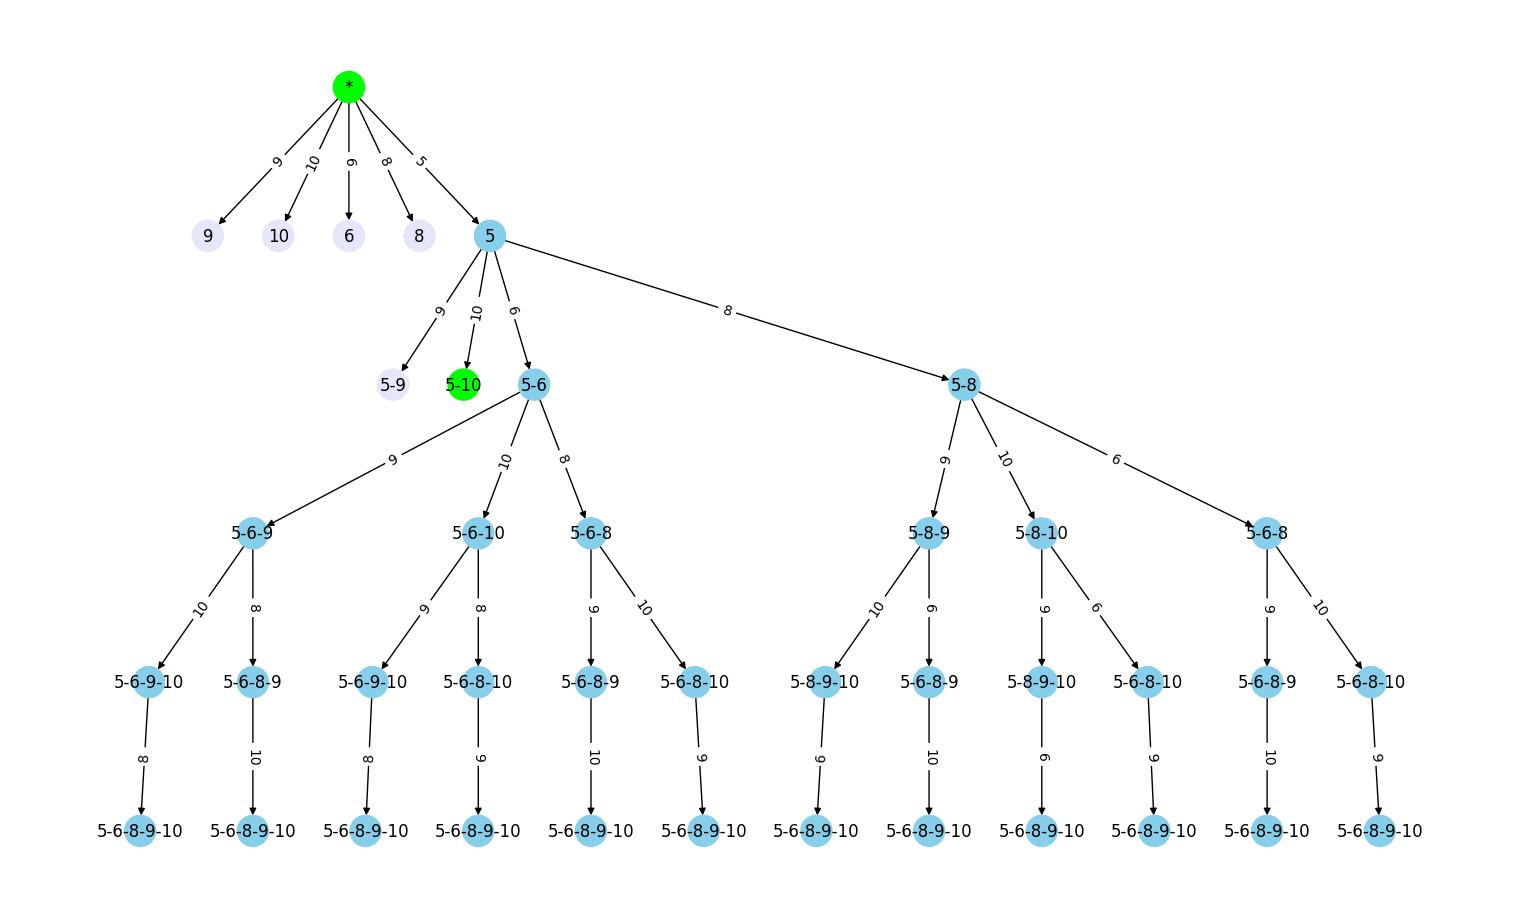

In [9]:
array, goal = problem(5, display_graph=False)
tree = tree_search(array, goal, strategy="df")

plt.figure(figsize=(15, 9))
pos = graphviz_layout(tree, prog="dot")  # dot neato twopi circo fdp sfdp
nx.draw(
    tree,
    pos=pos,
    node_color=[c for _, c in tree.nodes(data="color")],
    with_labels=True,
    labels={n: l for n, l in tree.nodes.data("label")},
    node_size=500,
)
nx.draw_networkx_edge_labels(tree, pos=pos, edge_labels=nx.get_edge_attributes(tree, "label"))
None

Found a solution in 35 steps: (5, 10)


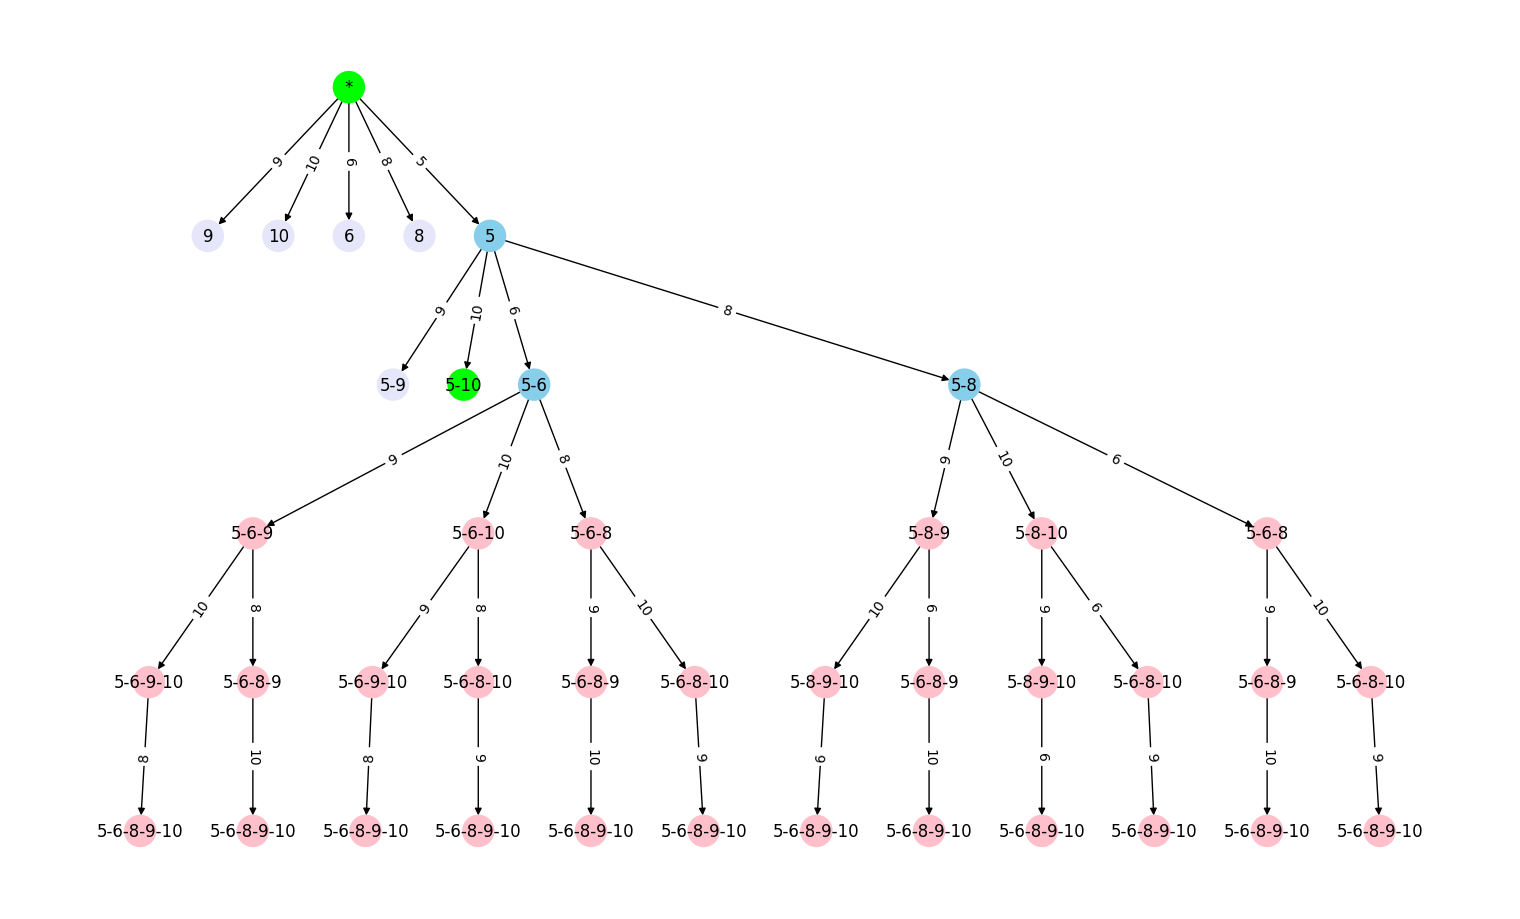

In [10]:
tree = tree_search(array, goal, strategy="df", bound="mark")

plt.figure(figsize=(15, 9))
pos = graphviz_layout(tree, prog="dot")  # dot neato twopi circo fdp sfdp
nx.draw(
    tree,
    pos=pos,
    node_color=[c for _, c in tree.nodes(data="color")],
    with_labels=True,
    labels={n: l for n, l in tree.nodes.data("label")},
    node_size=500,
)
nx.draw_networkx_edge_labels(tree, pos=pos, edge_labels=nx.get_edge_attributes(tree, "label"))
None

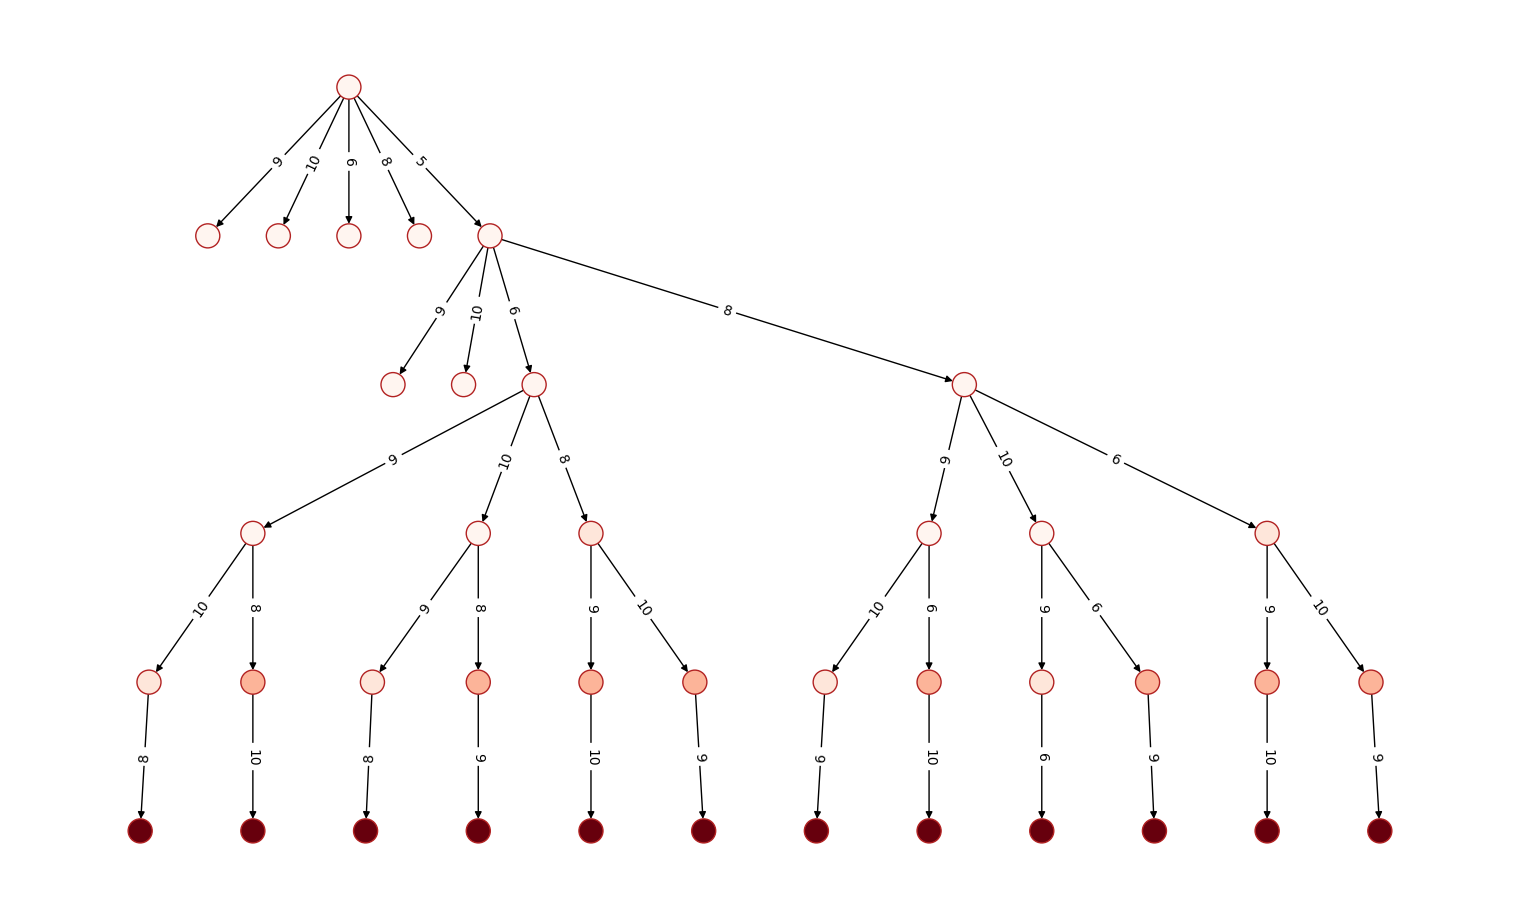

In [11]:
plt.figure(figsize=(15, 9))
nx.draw(
    tree,
    pos=pos,
    node_color=[c for _, c in tree.nodes(data="count")],
    cmap=plt.cm.Reds,
    with_labels=False,
    linewidths=1,
    edgecolors="firebrick",
)
nx.draw_networkx_edge_labels(tree, pos=pos, edge_labels=nx.get_edge_attributes(tree, "label"))
None

Found a solution in 11 steps: (5, 10)


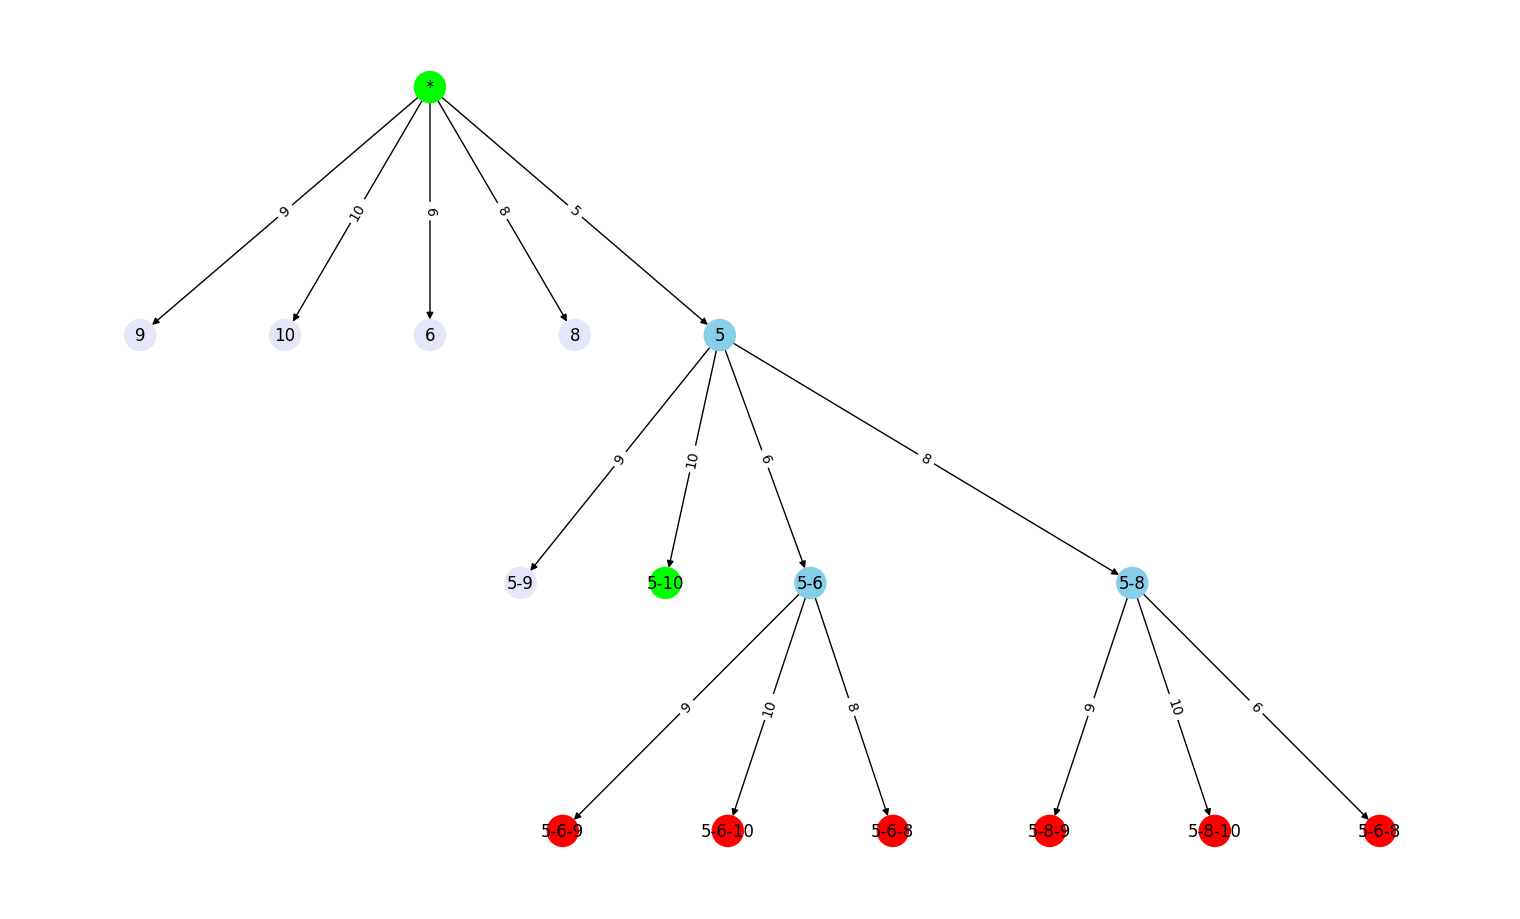

In [12]:
tree = tree_search(array, goal, strategy="df", bound=True)

plt.figure(figsize=(15, 9))
pos = graphviz_layout(tree, prog="dot")  # dot neato twopi circo fdp sfdp
nx.draw(
    tree,
    pos=pos,
    node_color=[c for _, c in tree.nodes(data="color")],
    with_labels=True,
    labels={n: l for n, l in tree.nodes.data("label")},
    node_size=500,
)
nx.draw_networkx_edge_labels(tree, pos=pos, edge_labels=nx.get_edge_attributes(tree, "label"))
None